# Modelling, Simulation, and Prediction of Water Consumption in the Ruhr Area (Project “IMProvT II”)

## Project Report


In [79]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import datetime as dt

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import accuracy_score

from sktime.forecasting.ets import AutoETS 
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.var import VAR

from statsforecast.models import AutoARIMA, SeasonalNaive, ETS, MSTL
from statsforecast import StatsForecast

from sklearn.preprocessing import StandardScaler

from river import anomaly
from river import datasets
from river import metrics
from river import time_series
from river import compose
from river import preprocessing
from river import linear_model
from river import optim

from report_utils import eval_sktime
from report_utils import eval_river
from report_utils import eval_sktime_multi

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [80]:
sns.mpl.rc("figure", figsize=(12, 6))
sns.mpl.rc("font", size=12)
sns.set_style("whitegrid")

## Table of Contents
* [1 Introduction](#chapter1)
    * [1.1 Research Question](#section_1_1)
    * [1.2 Data Analysis](#section_1_2)
* [2 Initial Experiments](#chapter2)
    * [2.1 Batch Learning Algorithms](#section_2_1)
        * [2.1.1 MSTL Model](#sub_section_2_1_1)
        * [2.1.2 Other Batch Learning Algorithms](#sub_section_2_1_2)
    * [2.2 Online Machine Learning Algorithms](#section_2_2)
        * [2.2.1 HoltWinters](#sub_section_2_2_1)
        * [2.2.2 SNARIMAX](#sub_section_2_2_2)
* [3 Method Comparison](#chapter3)
    * [3.1 Evaluation Function](#section_3_1)
    * [3.2 Benchmarking](#section_3_2)
* [4 Hyperparameter Tuning](#chapter4)
    * [4.1 SNARIMAX HP-Tuning](#section_4_1)
    * [4.2 Holt-Winters HP-Tuning](#section_4_2)
* [5 Multivariate Forecasting](#chapter5)
    * [5.1 Data Preparation](#section_5_1)
    * [5.2 Exploratory Data Analysis](#section_5_2)
    * [5.3 Forecasting Experiment](#section_5_3)
* [6 Conclusion](#chapter6)
    * [6.1 Batch vs. Online](#section_6_1)
    * [6.2 Univariate vs. Multivariate](#section_6_2)

## 1 Introduction <a class="anchor" id="chapter1"></a>

### 1.1 Research Question <a class="anchor" id="section_1_1"></a>

Water supply systems represent an essential part of our infrastructure. Due to extreme weather events such as heat waves or droughts, the energy providers find it increasingly difficult to forecast the future water consumption of the population. In order to ensure the supply, especially during peak consumption, methods of simulation based on artificial intelligence can be used. 
Various algorithms from the field of time series analysis are used for this purpose. Primarily, these models are trained with existing data at a certain time to use the model for future predictions. With this approach, the model must be re-trained with the entire data if we want to update it. We call this method "batch learning".  
Depending on the size of the data set, this approach can be costly in terms of computation time and computational power.
Therefore, modern approaches deal with online machine-learning models. The idea is that models are updated with newly acquired data and are not trained again with the entire data set. This leads to savings in terms of computation time. However, online machine learning algorithms often do not perform as well as classic batch learning models and have a more significant prediction error. In this case study, we obtain data from a large German water provider and try to make plausible predictions regarding water consumption using different algorithms. The question is whether online machine learning algorithms are a valuable alternative to traditional batch learning approaches.
We also want to perform a simple experiment regarding multivariate time series prediction. For this purpose, we consider weather conditions such as relative humidity besides the total consumption itself.

### 1.2 Data Analysis <a class="anchor" id="section_1_2"></a>

The dataset we use for univariate time series analysis consists of 51,706 data. The frequency is hourly, and all data contain a time stamp as well as a value for the water consumption of the respective hour. For this case study, this data has already been preprocessed and therefore does not contain any missing values.

In [81]:
data = pd.read_csv("UnivariateData.csv", header=0,index_col=0, parse_dates=True, sep=r'\s*,\s*')
data

,Consumption
Time,
2016-12-31 23:00:00+00:00,10951.217000
2017-01-01 00:00:00+00:00,10045.635920
2017-01-01 01:00:00+00:00,9365.640960
2017-01-01 02:00:00+00:00,8549.496080
2017-01-01 03:00:00+00:00,8345.553520
...,...
2022-11-25 04:00:00+00:00,9057.555808
2022-11-25 05:00:00+00:00,11226.519490
2022-11-25 06:00:00+00:00,12747.312330


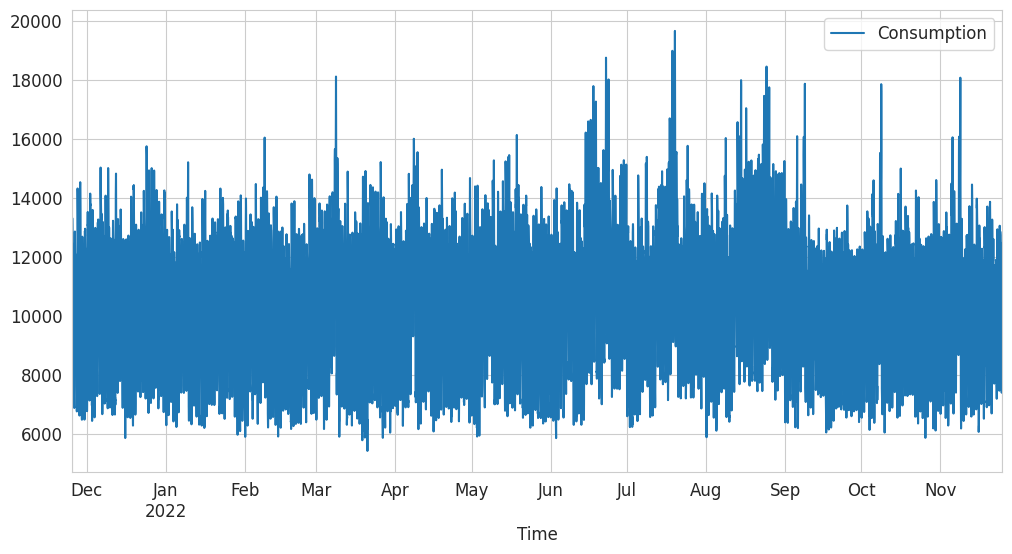

In [82]:
data[len(data)-24*365:].plot()
plt.show()

#### 1.2.1 PACF

Partial auto-correlation refers to the correlation between a time series and its own lagged values, while controlling for the values of intervening observations. It measures the direct effect of a past value on the current value after removing the influence of any intermediate values. In time series analysis, partial auto-correlation is used to identify any underlying patterns or trends in the data and to determine the optimal number of lagged values to include in a model for forecasting future values. In our case, we can use the result for example to determine the order of an auto regressive algorithm.
Below we see partial autocorrelation analyses for different horizons (one day, one week, 28 days).
If we look at the autocorrelation graph of the last 24 hours, we see that especially the last 3 hours are relevant for predicting the next data point. If we enlarge the horizon (e.g., 28 days), it becomes clear that the last 24 hours contain the most relevant information regarding a prediction of the near future.

##### PACF 24 Hours

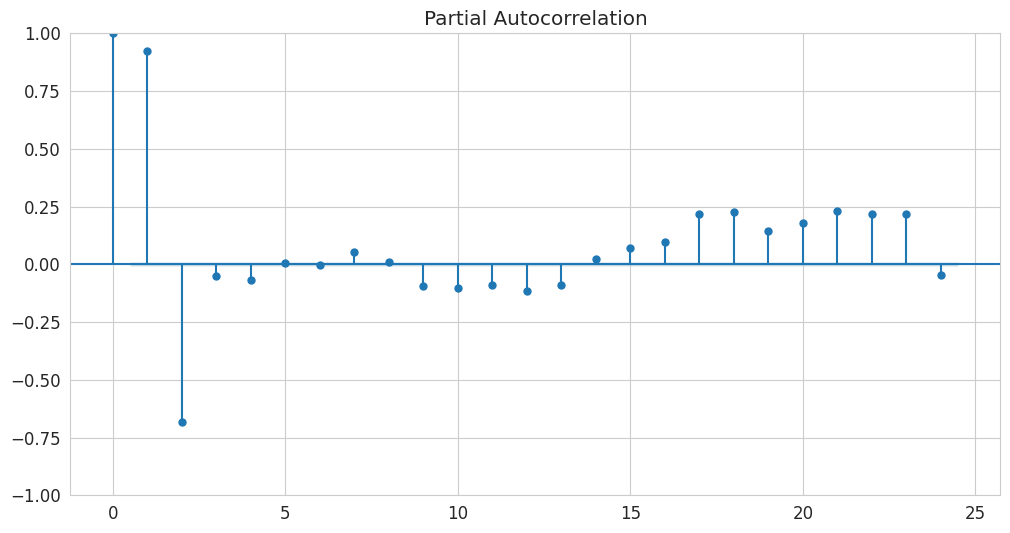

In [83]:
plot_pacf(data["Consumption"], lags=24)
plt.show()

##### PACF one Week

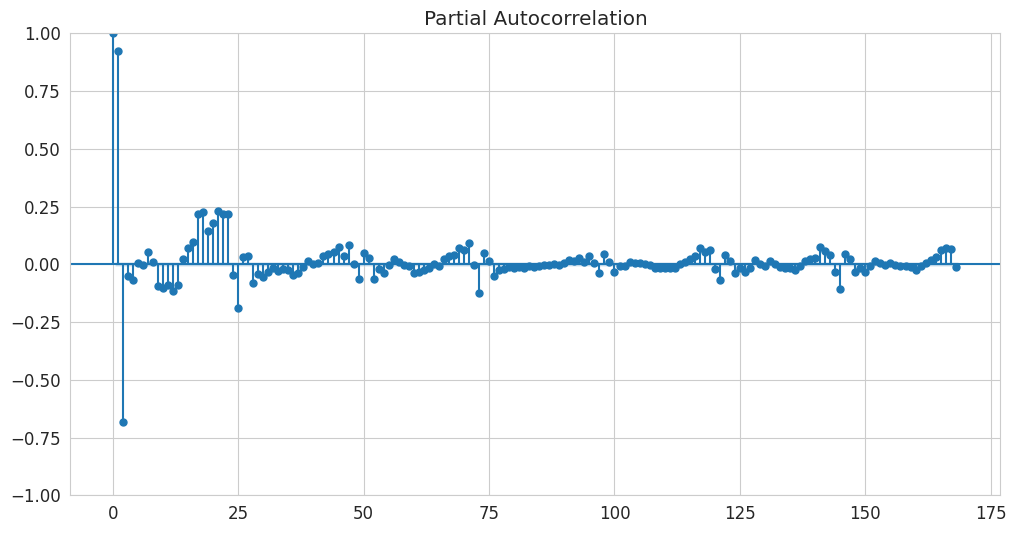

In [84]:
plot_pacf(data["Consumption"], lags=24*7)
plt.show()

##### PACF 28 Days

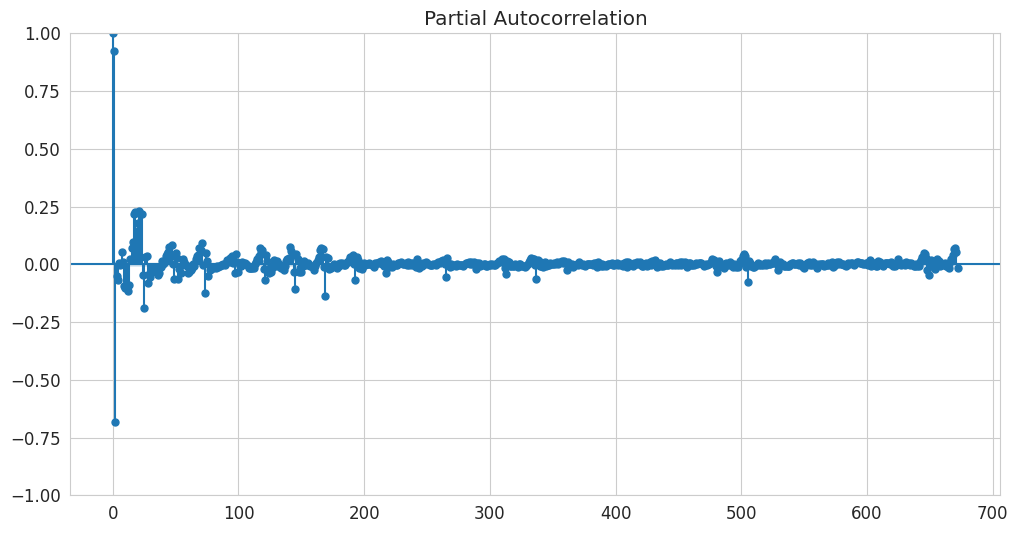

In [85]:
plot_pacf(data["Consumption"], lags=24*28)
plt.show()

#### 1.2.2 Decomposition of Time Series Data



The time series data can be decomposed into different components as following:

1. Trend
2. Seasonality
3. Residual

These are combined in additive or multiplicative way. Multiplicative decomposition means that we multiply the different components. Our time series does not show multiplicative behaviour. Therefore, we use the `seasonal_decompose()` function to decompose the series in an addtive way.

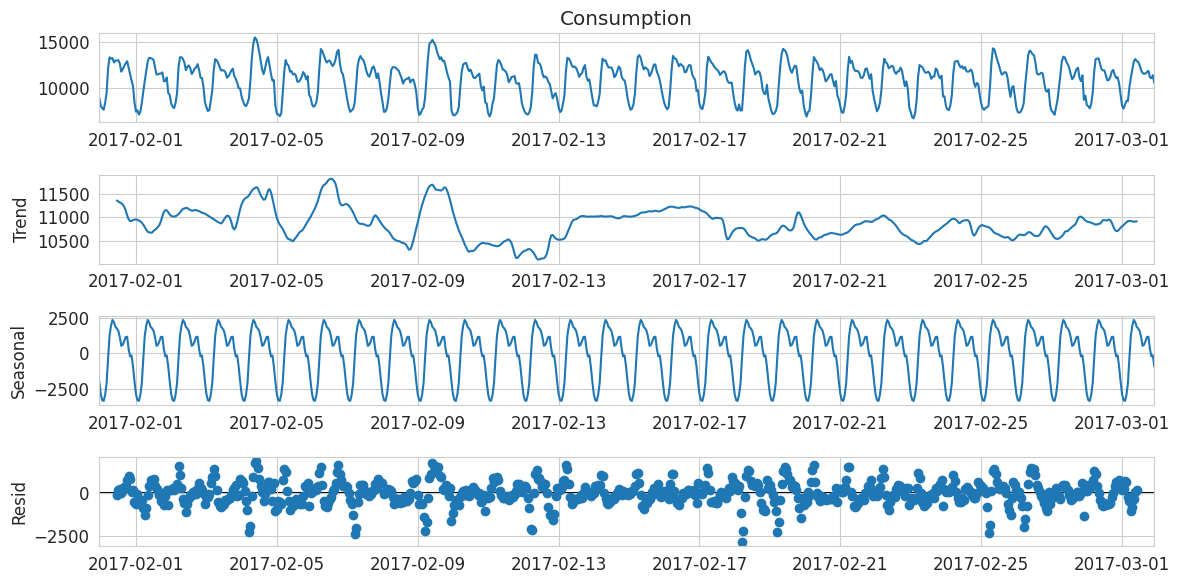

In [86]:
#Understanding components of unsampled data over a month (720 hours)
result = seasonal_decompose(data["Consumption"][720:1440], model='additive')
result.plot();

The seasonal behavior of the water consumption can be observed clearly when considering one month time window(720 hours). The daily seasonality repeats itself every 24 hours.

**Sampling**  
Decomposition is also conducted using different sample frequencies to observe the trend and seasonality of water consumption time series data.

**Weekly and Monthly sampled water consumption**

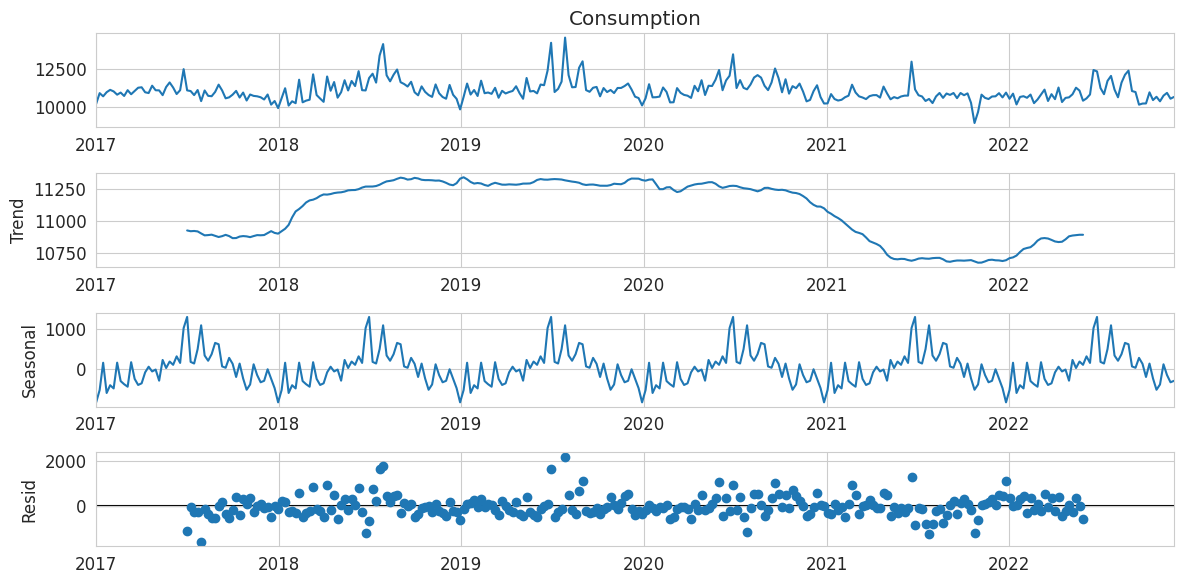

In [87]:
# Weekly result
df_weekly = data["Consumption"].resample('W').mean() 
result = seasonal_decompose(df_weekly, model="additive")
result.plot();

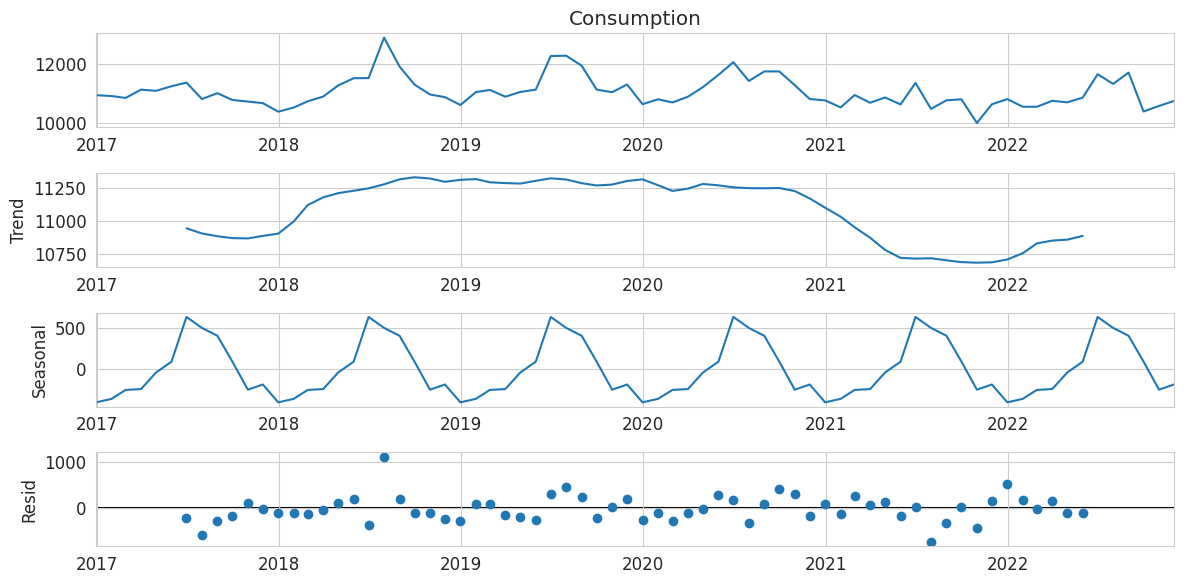

In [88]:
# Monthly Result
df_monthly = data["Consumption"].resample('M').mean()
result = seasonal_decompose(df_monthly,model="additive")
result.plot();

Water consumption can be assesed based on four seasons over a year. In the weekly and monthly sampled data, it is seen that the water consumption reaches peak in the middle of the year i.e. summer season. Similarly, the consumption is relatively low at the end of the year (winters). Based on the Seasonality analysis and the PACF, we see that the clearest seasonality, as well as the number of lags to consider, is 24. We will use this value as a basis for different algorithms in the following.

## 2 Initial Experiments <a class="anchor" id="chapter2"></a>

We set up different models to analyze the time series in the first step. Here we use the same experimental conditions for all experiments. We define the last 24 hours of the time series as a test set and train the model with the remaining data of the data set. By using this setup, no perfect evaluation can be made concerning the performance of the algorithms since we only consider the evaluation for a small part of the dataset. This step only serves as a proof of concept to filter out suitable methods. More advanced evaluation methods are introduced in chapter three.

### 2.1 Batch Learning Algorithms <a class="anchor" id="section_2_1"></a>

#### 2.1.1 MSTL Model <a class="anchor" id="sub_section_2_1_1"></a>

Water consumption data can have different seasonalities. For example, consumption is likely higher during the day than at night or higher in summer than in winter. For this reason, it makes sense to test models where it is possible to define more than one seasonality. We  implement three models for this purpose. The first one includes a seasonality of 24 hours, and the second consists of a daily and weekly seasonality. In the third model, we consider three seasonalities (daily, weekly, and yearly). 

In [89]:
data = pd.read_csv("UnivariateData.csv", header=0, parse_dates=True, sep=r'\s*,\s*')


In [90]:
unique_id = ['WaterConsumption'] * len(data)
data["unique_id"] = unique_id
data.rename(columns = {'Time':'ds', 'Consumption':'y'}, inplace = True)
data['ds'] = pd.to_datetime(data['ds'], format = '%Y-%m-%d %H:%M:%S')
data['ds'] = data['ds'].dt.tz_localize(None)

training_years = 1
training_period = 24*365*training_years+24
train = data[(len(data)-training_period):(len(data)-24)]
test = data[(len(data)-24):]

mstl_1 = MSTL(
    season_length=[24],
    trend_forecaster=AutoARIMA())
mstl_2 = MSTL(
    season_length=[24, 24 * 7], 
    trend_forecaster=AutoARIMA())
mstl_3 = MSTL(
    season_length=[24, 24 * 7, 365*7], 
    trend_forecaster=AutoARIMA())

sf1 = StatsForecast(
    models = [mstl_1],
    freq = 'H',
    n_jobs = -1)
sf2 = StatsForecast(
    models = [mstl_2],
    freq = 'H',
    n_jobs = -1)
sf3 = StatsForecast(
    models = [mstl_3],
    freq = 'H',
    n_jobs = -1)

sf1.fit(train)
sf2.fit(train)
sf3.fit(train)

forecasts1 = sf1.predict(h=24, level=[90])
forecasts2 = sf2.predict(h=24, level=[90])
forecasts3 = sf3.predict(h=24, level=[90])

test["ds"]=pd.to_datetime(test["ds"])
Y_hat_df = test.merge(forecasts1, how='left', on=['unique_id', 'ds'])
Y_hat_df = Y_hat_df.merge(forecasts2, how='left', on=['unique_id', 'ds'])
Y_hat_df = Y_hat_df.merge(forecasts3, how='left', on=['unique_id', 'ds'])

If we look at the results of the three different seasonality setups, we see that the algorithm which only considers one seasonality (24h)  performs best. However, this may be because our tests only assume a forecast horizon of 24 hours. This indicates that the last 24 hours have the highest relevance for predicting the seasonality of the next 24 hours.

In [91]:
y_true = test['y'].values
mstl_1_preds = Y_hat_df['MSTL_x'].values
mstl_2_preds = Y_hat_df['MSTL_y'].values
mstl_3_preds = Y_hat_df['MSTL'].values
print('MSTL with daily seasonality MAE: %0.3f' % mae(mstl_1_preds, y_true))
print('MSTL with daily and weekly seasonality: %0.3f' % mae(mstl_2_preds, y_true))
print('MSTL with daily, weekly and yearly seasonality: %0.3f' % mae(mstl_3_preds, y_true))

MSTL with daily seasonality MAE: 277.537
MSTL with daily and weekly seasonality: 445.139
MSTL with daily, weekly and yearly seasonality: 1842.019


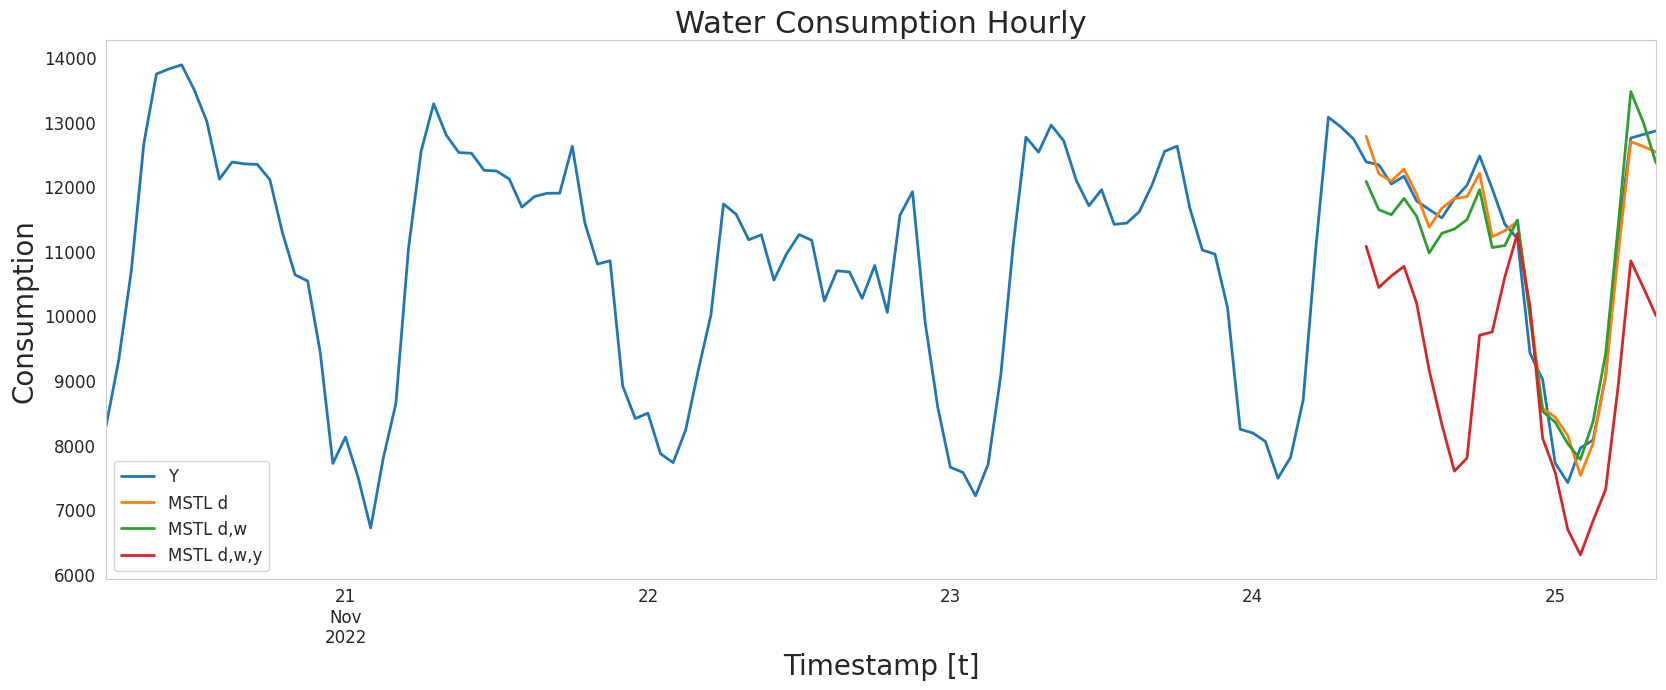

In [92]:
plot_data = test
plot_data["ds"]=pd.to_datetime(plot_data["ds"])

_, ax = plt.subplots(1, 1, figsize = (20, 7))
df_plot = pd.concat([train.tail(100), Y_hat_df]).set_index('ds').tail(24 * 7)
df_plot[['y', 'MSTL_x', 'MSTL_y', 'MSTL']].plot(ax=ax, linewidth=2)
ax.set_title('Water Consumption Hourly', fontsize=22)
ax.set_ylabel('Consumption', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(['Y', 'MSTL d','MSTL d,w','MSTL d,w,y'])
ax.grid()

#### 2.1.2 Other Batch Learning Models (sktime) <a class="anchor" id="sub_section_2_1_2"></a>

To compare other algorithms, we use some implementations of the library "sktime". Initially, we also worked with methods of the "statsforecast" library. However, the functions of this package cannot be implemented in the evaluation function, which we will present in the next chapter. We compare the following three approaches:

**AutoETS:** The name AutoETS stands for "Automatic Exponential Smoothing". It is an algorithm for time series forecasting, where the future values of a time series are predicted based on past observations. The algorithm is based on the idea of exponential smoothing, which involves giving more weight to recent observations and less weight to older observations. We set the`auto` feature to `True`, to find the the best parameter set up automatically. We define `sp` = 24, which describes the number of periods in the seasonal cycle.

**AutoArima:** AutoARIMA stands for "Automatic AutoRegressive Integrated Moving Average". The algorithm consists of the autoregressive part as well as the moving average of the ARMA model. It also uses differentiation and trend determination to remove trends and establish stationarity.   

**Naive Forecaster:** In Contrast to the other two methods, the Naive Forecaster is a simple time series forecasting method. It is built on the assumption that the future values of a time series will be equal to the most recent observed value. The method is commonly used as a baseline comparison for other, more sophisticated forecasting methods. For this approach, we define the seasonal periodicity of 24 hours.

In [93]:
def remove_timezone(dt):
    return dt.replace(tzinfo=None)

In [94]:
df = pd.read_csv('pre_processed_Raw_data_demand_Hal_freq_60.csv', parse_dates = True)
df = df.rename(columns ={'Unnamed: 0':'Time'}, inplace=False) #rename the unnamed time column 
df['Time']=pd.to_datetime(df['Time'],format = '%Y-%m-%d %H')
df['Time'] = df['Time'].apply(remove_timezone)
df = df.set_index('Time')
df.index.freq = 'H'
df_sktime=df.squeeze()

fh = np.arange(1, 24)

forecaster_ets = AutoETS(auto=True, n_jobs=-1, sp=24)
forecaster_arima = StatsForecastAutoARIMA(sp=12, d=1, max_p=2, max_q=2)
forecaster_naive = NaiveForecaster(strategy="last", sp = 24)

df_train = df[:len(df_sktime)-24]
df1 = df_train

forecaster_ets.fit(df1, fh = fh)
forecaster_arima.fit(df1, fh = fh)
forecaster_naive.fit(df1, fh = fh)
warnings.filterwarnings('ignore')

y_pred_ets = forecaster_ets.predict(fh)
y_pred_arima = forecaster_arima.predict(fh)
y_pred_naive = forecaster_naive.predict(fh)
y_true = df[len(df)-24:]

The interesting result of this simple test shows that the Naive Forecaster performs best in forecasting the last 24 hours of the data set. This could be because various factors influence water consumption (weather, holidays, etc.). Since these external factors are not considered here, the algorithm treats it as randomness. The Naive Forecaster only duplicates one value that is defined by the seasonal periodicity. According to experience, it produces good results for time series data with a high level of randomness. 

In [95]:
print('AutoETS MAE: %0.3f' % mae(y_pred_ets, y_true))
print('AutoARIMA MAE: %0.3f' % mae(y_pred_arima, y_true))
print('Naive forecaster MAE: %0.3f' % mae(y_pred_naive, y_true))

AutoETS MAE: 794.806
AutoARIMA MAE: 765.969
Naive forecaster MAE: 344.347


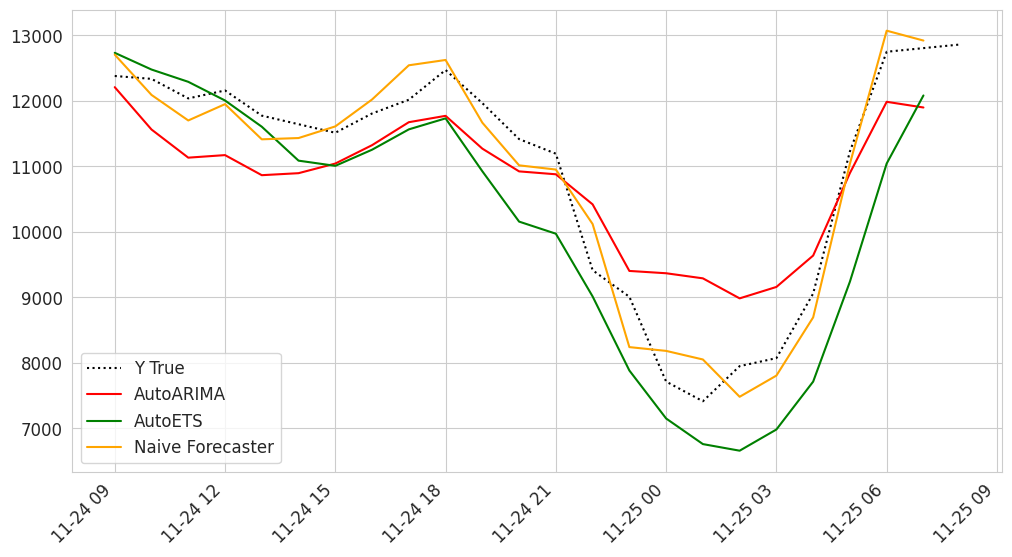

In [96]:
plt.plot(y_true, color = 'black', label = 'Y True', linestyle = 'dotted')
plt.plot(y_pred_arima, color='red', label = 'AutoARIMA')
plt.plot(y_pred_ets, color='green', label = 'AutoETS')
plt.plot(y_pred_naive, color='orange', label = 'Naive Forecaster')
plt.legend(loc="lower left")
plt.xticks(rotation=45, ha='right')
plt.show()

### 2.2 Online Machine Learning Algorithms <a class="anchor" id="section_2_2"></a>

The case study's basic idea is to determine whether online machine learning algorithms are reasonable alternatives to classical batch learning methods. In a continuous process, where new data is constantly generated, these approaches can offer a significant advantage since the models are not trained from scratch with each new data but are updated incrementally. However, the achieved accuracy is often not as good as that of the batch learning approaches. In order to test these kind of algorithms, we perform experiments with implementations from the python library "river". As for the batch learning experiments, we test the models with the last 24 hours of the data while training the algorithms with the rest of the dataset. The difference is in the training method. In river, we simulate a data pipeline where the model is updated with successively arriving data. River provides the function `learn_one()` for this purpose. We use the following two forecasting methods:

#### 2.2.1 Holt-Winters <a class="anchor" id="sub_section_2_2_1"></a>

The Holt-Winters algorithm is based on the exponential smoothening method. Here, the forecasts are made using moving averages. The exponential part ensures that values from the near past have more influence than observations from the distant past. In the Holt-Winters forecast, three exponential smoothing equations are considered (level, trend and seasonality). We set a smoothing parameter for all three components. Here we assume small values for the parameters of level and trend for a first test. The lower the value, the higher the influence of distant values. For the seasonality smoothing parameter we have assumed a higher value. This means that the influence of the near past on the seasonality prediction is higher than for level and trend.

In [97]:
data = pd.read_csv("UnivariateData.csv", header=0, parse_dates=True, sep=r'\s*,\s*')
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z').date() for date in data["Time"]]

x = [{'Time': x.toordinal()} for x in dates_list]

dataNP = data["Consumption"].to_numpy()
y = dataNP.flatten()

y_train = y[:(len(data)-24)]
x_train = x[:(len(data)-24)]
y_test = y[(len(data)-24):]
x_test = x[(len(data)-24):]

model = compose.Pipeline(
    #('ordinal_date', compose.FuncTransformer(get_ordinal_date)),
    ('HOLTWINTERS', time_series.HoltWinters(
     alpha=0.005, #level smoothing parameter
     beta=0.005, #trend smoothing parameter
     gamma=0.5, #seasonality smoothing parameter
     seasonality=24,
     multiplicative=True)))

for x,y in zip(x_train, y_train):
        model = model.learn_one(x, y)

forecast = model.forecast(horizon=len(x_test))

test_times = data["Time"][len(data)-24:]
dates = []
for x in test_times:
    dates.append(x)

Interestingly, in this simple test, we already achieved better results with the Holt-Winters online method than with all batch learning methods tested. However, this test is not extensive enough to really make a statement about the performance since we only test the models in relation to the last 24 hours. In a later part of the case study, more professional evaluation methods are used to verify the assumption of this experiment.

In [98]:
print('HoltWinters MAE: %0.3f' % mae(y_test, forecast))

HoltWinters MAE: 281.146


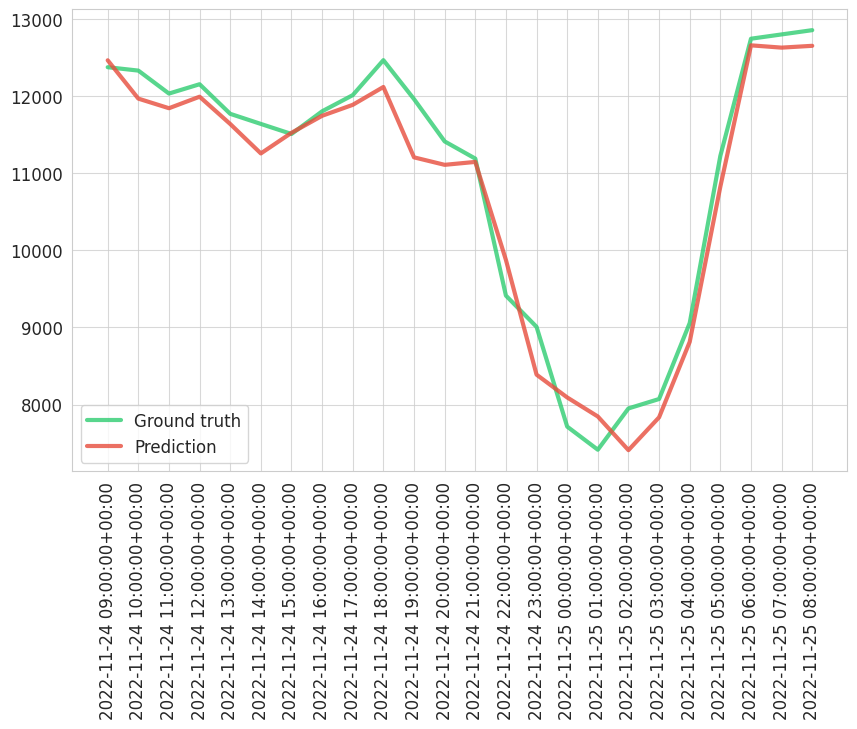

In [99]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_test, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, forecast, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
ax.legend()

#### 2.2.2 SNARIMAX <a class="anchor" id="sub_section_2_2_2"></a>

The SNARIMAX algorithm is also a river implementation. The name stands for "seasonal non-linear AutoRegressive Integrated Moving-Average with exogenous inputs". This implementation provides an interface for the implementation of different forecasting methods. This means methods like AR, MA, ARMA, or ARIMA can be used by setting up different parameter configurations. For the first test, we use a standard setup from the river documentation for an ARIMA model.  Since this model is so versatile and complex, hyperparameter tuning algorithms should be used for further tests. It is difficult to determine the parameters purely analytically.

In [100]:
data = pd.read_csv("UnivariateData.csv", header=0, parse_dates=True, sep=r'\s*,\s*')
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z').date() for date in data["Time"]]

x = [{'Time': x.toordinal()} for x in dates_list]

dataNP = data["Consumption"].to_numpy()
y = dataNP.flatten()

training_years = 6
training_period = 24*365*training_years+24

y_train = y[(len(data)-training_period+24):(len(data)-24)]
x_train = x[(len(data)-training_period+24):(len(data)-24)]
y_test = y[(len(data)-24):]
x_test = x[(len(data)-24):]

model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
     time_series.SNARIMAX(
         p=1, # order of autoregressive part
         d=0, # differencing order
         q=1, # order of moving average part
         m=24, # seasonal order for seasonal pattern
         sp=3, # seasonal order auto regressive part
         sq=6, # seasonal order moving average part 
         regressor=(
             preprocessing.StandardScaler() |
             linear_model.LinearRegression(
                 intercept_init=110,
                 optimizer=optim.SGD(0.01),
                 intercept_lr=0.3
             )
         )
     )
 )

for x,y in zip(x_train, y_train):
        model = model.learn_one(x, y)

forecast = model.forecast(horizon=len(x_test))


Although we did not tune the parameters, the first results are surprisingly good compared to the batch learning algorithms. However, the computation time seems longer than for the Holt-Winters method. We also revisit this algorithm in the evaluation chapter to assess that. 

In [101]:
print('SNARIMAX MAE: %0.3f' % mae(y_test, forecast))

SNARIMAX MAE: 382.888


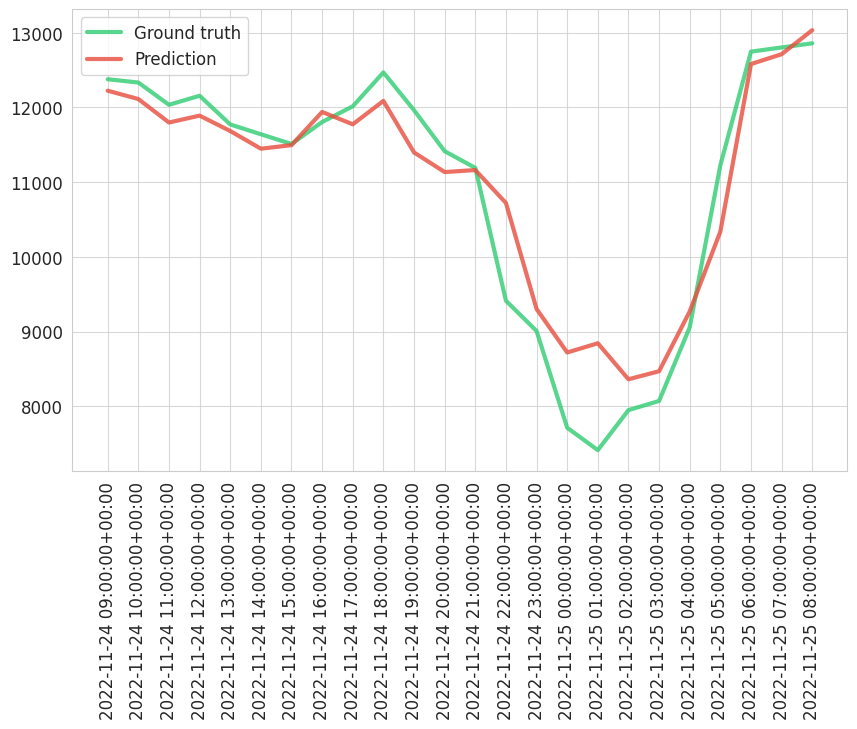

In [102]:
test_times = data["Time"][len(data)-24:]

df = pd.DataFrame(
    [x, y_pred] for x, y_pred in zip(test_times, forecast))
df

fig, ax = plt.subplots(figsize=(10, 6))
ax.grid(alpha=0.75)
ax.plot(dates, y_test, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
ax.plot(dates, forecast, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
ax.legend()

## 3. Method Comparison <a class="anchor" id="chapter3"></a>

### 3.1 Evaluation Function <a class="anchor" id="section_3_1"></a>

In chapter two, we describe various algorithms and conduct initial tests with them. However, we evaluate all methods using a test set that included only the last 24 hours. Therefore, in this chapter, we use more advanced techniques to make a more precise statement about the performance of the algorithms in relation to our problem. In addition, we evaluate the methods concerning training time and memory consumption.
To ensure that all case study groups use the same evaluation technique, we use a method developed by group one. We convert it into three functions (`eval_sktime`, `eval_river` and `eval_sktime_multi`) that are compatible with our algorithms. The functions can be found in the attached folder `report_utils` under `evaluation_functions.py`.
Within the function, we can implement various evaluation techniques through different setups. These are shown in Figure 1. 

1) We use the first technique in Chapter 2. Here, the model is trained using a fixed training set and validated using a single test set.

2) The second technique also involves a single training set. However, the model is tested by means of different horizons. Since the algorithm is trained only once and is not trained again during the evaluation, methods like `append` and `update` have to be used here to avoid gaps within the time series until the next test set. 

3) In the third method, we first train the model with an original data set. Then, the algorithm is evaluated with the first test set. After this evaluation, we train the entire model again and add the data up to the second test set to the training set. Then we test the model with the second test set, train it up to the third test set, and so on. 

Since method three results in very high training times, especially for algorithms with integrated hyperparameter tuners (e.g. `AutoArima`, `AutoETS`, etc.) and produces only little improvements in performance, we only use the second method for our experiments in this report. 

<img src="report_images/batchOptions.png"  width="800" height="395">
<figcaption align = "center"><b>Fig.1: Evaluation options</b></figcaption>

### 3.2 Benchmarking <a class="anchor" id="section_3_2"></a>

We use the same input parameters of the evaluation function for the different algorithms to generate appropriate comparisons. 

* Prediction horizon: 24 hours
* Test period: The last 365 days of the data set

This means that the entire last year is evaluated using prediction horizons of one day. So we evaluate 365 times.

We compare three batch learning algorithms (`AutoARIMA`, `AutoETS`, `NaiveForecaster`) and two online machine learning models (`Holt-Winters`, `SNARIMAX`).

In [103]:
df = pd.read_csv('pre_processed_Raw_data_demand_Hal_freq_60.csv', parse_dates = True)
df = df.rename(columns ={'Unnamed: 0':'Time'}, inplace=False) #rename the unnamed time column 
df['Time']=pd.to_datetime(df['Time'],format = '%Y-%m-%d %H')
df['Time'] = df['Time'].apply(remove_timezone)
df = df.set_index('Time')
df.index.freq = 'H'
type(df)

pandas.core.frame.DataFrame

#### Batch Learning `sktime` Models

In [104]:
forecaster = NaiveForecaster(strategy="last", sp = 24) 

df_true_naive, df_eval_naive = eval_sktime(df = df,
                    model = forecaster,
                    target_col = "GESAMTVERBRAUCH",
                    horizon = 24,
                    forecast_intervall = 1,
                    test_period = 365,
                    percentage_cut_train = 0.0,
                    verbose = False,
                    retrain = False)

In [105]:
forecaster = StatsForecastAutoARIMA(sp=24, d=1, max_p=2, max_q=2)

df_true_ARIMA, df_eval_ARIMA = eval_sktime(df = df,
                    model = forecaster,
                    target_col = "GESAMTVERBRAUCH",
                    horizon = 24,
                    forecast_intervall = 1,
                    test_period = 365,
                    percentage_cut_train = 0.0,
                    verbose = False,
                    retrain = False)

In [106]:
forecaster = AutoETS(auto=True, n_jobs=-1, sp=24)

df_true_ETS, df_eval_ETS = eval_sktime(df = df,
                    model = forecaster,
                    target_col = "GESAMTVERBRAUCH",
                    horizon = 24,
                    forecast_intervall = 1,
                    test_period = 365,
                    percentage_cut_train = 0.0,
                    verbose = False,
                    retrain = False)

#### OML `river` Models

In [107]:
model = time_series.HoltWinters(
         alpha=0.005, #level smoothing parameter
         beta=0.005, #trend smoothing parameter
         gamma=0.5, #seasonality smoothing parameter
         seasonality=24,
         multiplicative=True)

df_true_hw, df_eval_hw = eval_river(df = df,
                            model = model,
                            target_col = "GESAMTVERBRAUCH",
                            horizon= 24,
                            forecast_intervall = 1,
                            test_period = 365,
                            percentage_cut_train = 0.0)

In [108]:
model = time_series.SNARIMAX(
         p=1, # order of autoregressive part
         d=0, # differencing order
         q=1, # order of moving average part
         m=24, # seasonal order for seasonal pattern
         sp=3, # seasonal order auto regressive part
         sq=6, # seasonal order moving average part 
     )

df_true_SNARIMAX, df_eval_SNARIMAX=eval_river(df = df,
                            model = model,
                            target_col = "GESAMTVERBRAUCH",
                            horizon=24,
                            forecast_intervall = 1,
                            test_period = 365,
                            percentage_cut_train = 0.0)

#### Comparison

**Time:**  
If we compare the different methods in terms of training time, we see that the two OML algorithms and the Naive Forecaster are significantly faster than the other two models (`AutoARIMA`, `AutoETS`). This is not surprising, however, as these two algorithms use integrated hyperparameter optimizations to determine the best parameters automatically. This process of hyperparameter tuning increases the calculation time significantly.


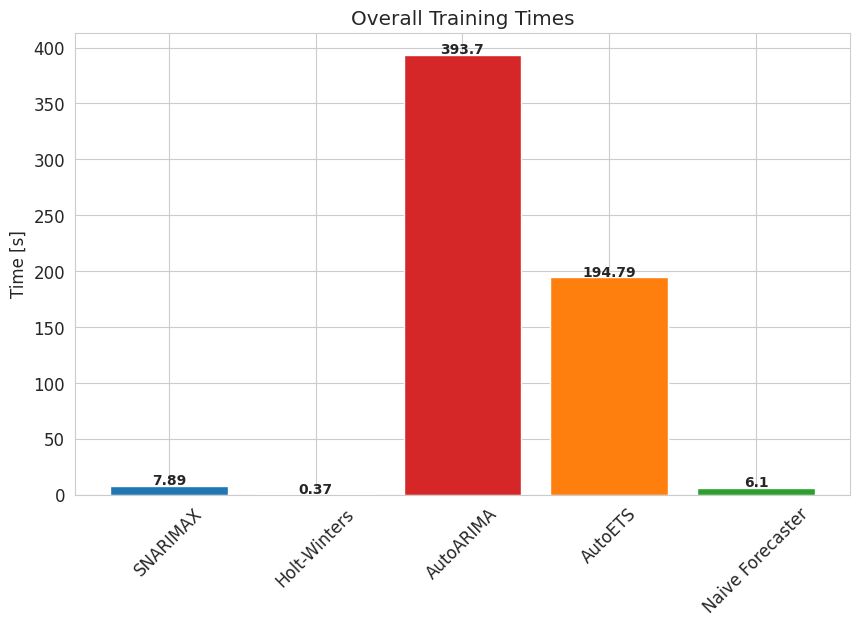

In [161]:
time_SNARIMAX = sum(df_eval_SNARIMAX["CompTime (s)"])
time_HW = sum(df_eval_hw["CompTime (s)"])
time_ARIMA = sum(df_eval_ARIMA["CompTime (s)"])
time_ETS = sum(df_eval_ETS["CompTime (s)"])
time_naive = sum(df_eval_naive["CompTime (s)"])

model = ['SNARIMAX','Holt-Winters',"AutoARIMA", 'AutoETS', 'Naive Forecaster']
times = [time_SNARIMAX, time_HW, time_ARIMA, time_ETS, time_naive]

bar_colors = ['tab:blue', 'tab:olive', 'tab:red', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model,times, color=bar_colors)
for index,data in enumerate(times):
    plt.text(x=index , y =data+1 , s=f"{round(data,2)}" , fontdict=dict(fontsize=10), horizontalalignment ="center", fontweight = "bold")
plt.ylabel("Time [s]")
plt.title('Overall Training Times')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=45)
plt.show()

**Memory:**  
In terms of memory consumption, it is similar. The OML algorithms cause the least utilization.

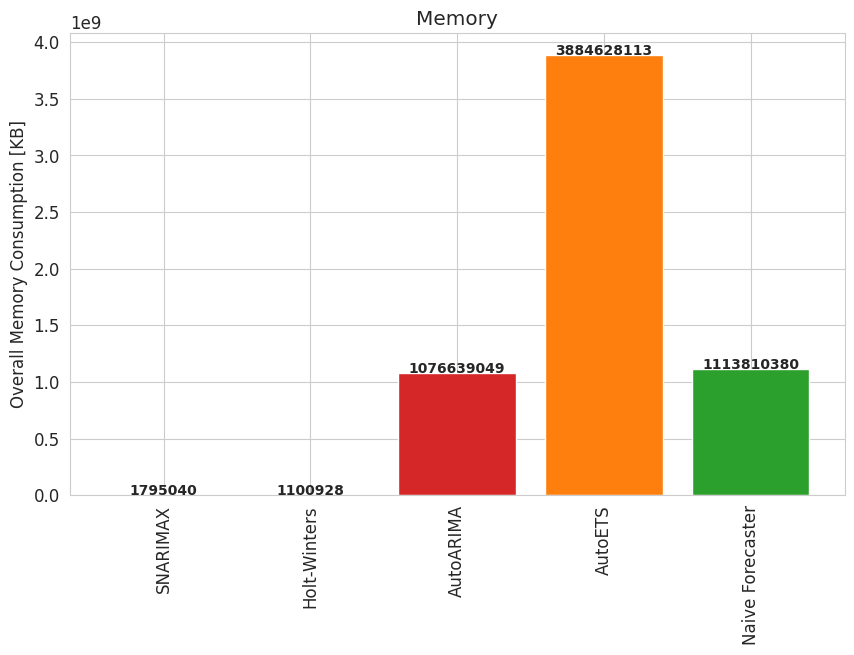

In [154]:
mem_SNARIMAX = sum(df_eval_SNARIMAX["Memory (KB)"])
mem_HW = sum(df_eval_hw["Memory (KB)"])
mem_ARIMA = sum(df_eval_ARIMA["Memory (KB)"])
mem_ETS = sum(df_eval_ETS["Memory (KB)"])
mem_naive = sum(df_eval_naive["Memory (KB)"])

model = ['SNARIMAX','Holt-Winters',"AutoARIMA", 'AutoETS', 'Naive Forecaster']
mems = [mem_SNARIMAX, mem_HW, mem_ARIMA, mem_ETS, mem_naive]

bar_colors = ['tab:blue', 'tab:olive', 'tab:red', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model,mems, color=bar_colors)
for index,data in enumerate(mems):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=10), horizontalalignment ="center", fontweight = "bold")
plt.ylabel("Overall Memory Consumption [KB]")
plt.title('Memory')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

**Performance:**  
When looking at the different performance results (the average mean absolute error from all evaluations), it can be seen that all algorithms except `AutoETS` produce similar results. Interestingly, the Holt-Winters approach achieves the best result, which means that online machine-learning algorithms could be an alternative. It should also be mentioned that these results were obtained with random standard setups of the OML algorithm parameters. The results could be improved through hyperparameter tuning, which is the next chapter's subject.


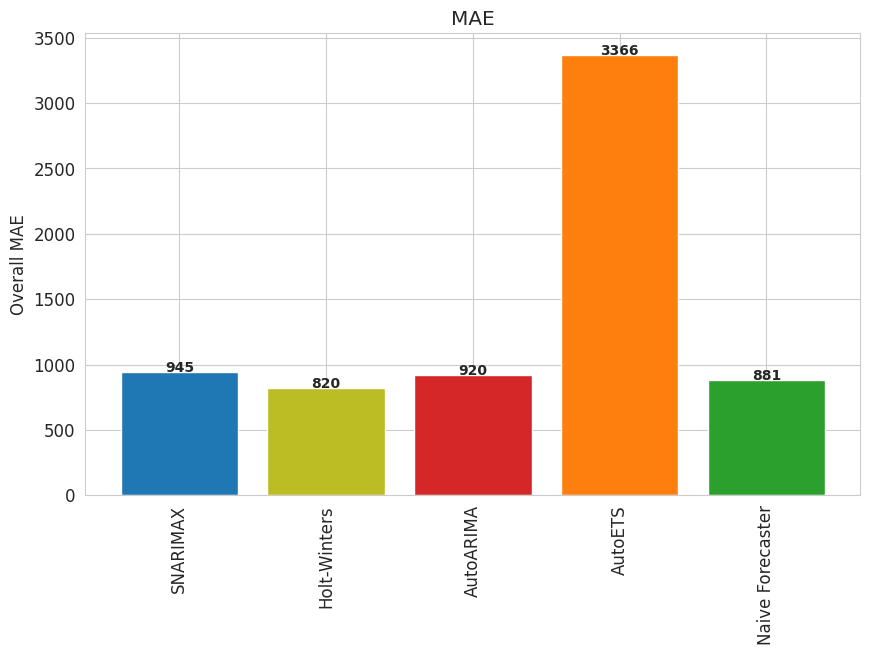

In [155]:
mae_ARIMA = np.mean(df_eval_ARIMA["MAE"])
mae_HW = np.mean(df_eval_hw["MAE"])
mae_SNARIMAX = np.mean(df_eval_SNARIMAX["MAE"])
mae_ETS = np.mean(df_eval_ETS["MAE"])
mae_naive = np.mean(df_eval_naive["MAE"])

model = ['SNARIMAX',
         'Holt-Winters',"AutoARIMA", 'AutoETS', 'Naive Forecaster']
maes = [mae_SNARIMAX,
        mae_HW, mae_ARIMA, mae_ETS, mae_naive]

bar_colors = ['tab:blue', 'tab:olive', 'tab:red', 'tab:orange', 'tab:green']


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model,maes, color=bar_colors)
for index,data in enumerate(maes):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=10), horizontalalignment ="center", fontweight = "bold")
plt.ylabel("Overall MAE")
plt.title('MAE')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

## 4. Hyperparameter Tuning <a class="anchor" id="chapter4"></a>

To generate the best possible results with the online machine learning algorithms, we optimize the hyperparameters of the two methods in this chapter. For this we use the 'spotRiver' package developed by Bartz Beielstein et al. Within this library there is the class `Hyperriver`. This class contains objective functions for the model-based hyperparameter optimization of online machine learning algorithms of the `river` implementation. These functions can be passed to the `spot` function to determine the hyperparameter setups that result in the lowest MAE values using surrogate model-based optimization. The hyperparameter optimization code can be viewed in the attached `report_spot` folder.

The evaluation function introduced in the last chapter, differs from the objective function implemented in Spot for the 'river' implementations of SNARIMAX and Holt-Winters. Spot uses the `evaluate` function that is a part river. This function forecasts the next 24 hours (or our horizon) for each sample of the data set. In the `evaluate` function, on the other hand, intervals within a defined training set are evaluated. This leads to different MAE values between hyperparameter optimization and evaluation function. Despite these minor differences in terms of evaluations, we are able to improve the performance of the algorithms. We exclude the last year of data for hyperparameter optimization to create a realistic set up. 

#### 4.1 SNARIMAX HP-Tuning <a class="anchor" id="section_4_1"></a>

After some tuning runs with different parameter setups, we could significantly improve the result of the SNARIMAX algorithm. In the analysis of the importance of the parameters (see 'report_spot/SPOT_SNARIMAX.ipynb'), we see that besides the seasonality (m), the values for the differencing order (d) and the order of the moving average part (q) have the strongest influence on the performance.

In [112]:
model = time_series.SNARIMAX(
                 p=1, # order of autoregressive part
                 d=0, # differencing order
                 q=1, # order of moving average part
                 m=24, # seasonal order for seasonal pattern
                 sp=3,# seasonal order auto regressive part
                 sd=1, # seasonal differencing order.
                 sq=2, # seasonal order moving average part 
                 regressor=(
                    preprocessing.StandardScaler() |
                    linear_model.LinearRegression(
                         intercept_init=110,
                         optimizer=optim.SGD(1.00419141e-03),
                         intercept_lr=4.81042464e-02
                     )))

df_true_SNARIMAX_tuned, df_eval_SNARIMAX_tuned=eval_river(df = df,
                                                            model = model,
                                                            target_col = "GESAMTVERBRAUCH",
                                                            horizon=24,
                                                            forecast_intervall = 1,
                                                            test_period = 365,
                                                            percentage_cut_train = 0.0)

mae_SNARIMAX_tuned = np.mean(df_eval_SNARIMAX_tuned["MAE"])
print('HoltWinters MAE without tuning:', mae_SNARIMAX)
print('HoltWinters MAE with tuning:', mae_SNARIMAX_tuned)
print('Improvement through hyperparameter tuning:',mae_SNARIMAX - mae_SNARIMAX_tuned)

HoltWinters MAE without tuning: 944.6821095890411- Test until 2022-11-25 08:00:00
HoltWinters MAE with tuning: 823.6696712328767
Improvement through hyperparameter tuning: 121.01243835616447


#### 4.2 Holt-Winters HP-Tuning <a class="anchor" id="section_4_2"></a>

When we apply the optimized hyperparameters for the Holt-Winters algorithm using the evaluation function, we achieve a slight improvement in the average mean absolute error. All hyperparameter tuning runs have a seasonality of 24 hours calculated as an optimized Parameter. The resulting smoothing parameters are close to zero after the optimization. This contrasts with our previous assumptions that the closest data have the strongest influence on the next prediction since low values indicate a higher impact of distant samples.

In [113]:
model = time_series.HoltWinters(
         alpha=6.05807874e-02, #level smoothing parameter
         beta=3.02409175e-03, #trend smoothing parameter
         gamma=8.95368888e-02, #seasonality smoothing parameter
         seasonality=24,
         multiplicative=True)

df_true_hw_tuned, df_eval_hw_tuned = eval_river(df = df,
                            model = model,
                            target_col = "GESAMTVERBRAUCH",
                            horizon= 24,
                            forecast_intervall = 1,
                            test_period = 365,
                            percentage_cut_train = 0.0)

In [114]:
mae_HW_tuned = np.mean(df_eval_hw_tuned["MAE"])
print('HoltWinters MAE without tuning:', mae_HW)
print('HoltWinters MAE with tuning:', mae_HW_tuned)
print('Improvement through hyperparameter tuning:',mae_HW - mae_HW_tuned)

HoltWinters MAE without tuning: 819.7393698630137
HoltWinters MAE with tuning: 789.8865205479452
Improvement through hyperparameter tuning: 29.85284931506851


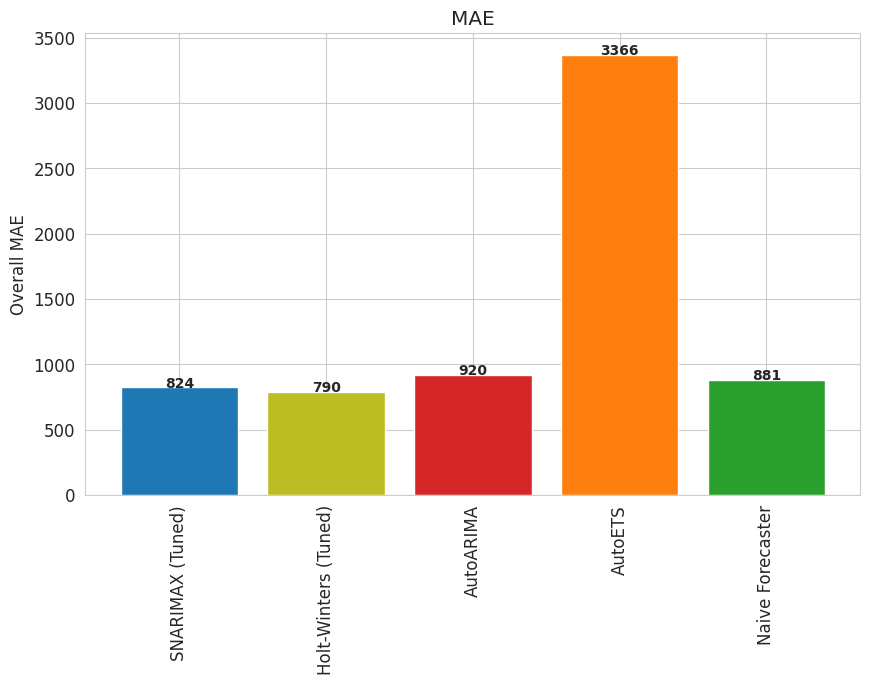

In [158]:
model = ['SNARIMAX (Tuned)',
         'Holt-Winters (Tuned)',"AutoARIMA", 'AutoETS', 'Naive Forecaster']
maes = [mae_SNARIMAX_tuned,
        mae_HW_tuned, mae_ARIMA, mae_ETS, mae_naive]

bar_colors = ['tab:blue', 'tab:olive', 'tab:red', 'tab:orange', 'tab:green']


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model,maes, color = bar_colors)
for index,data in enumerate(maes):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=10), horizontalalignment ="center", fontweight = "bold")
plt.ylabel("Overall MAE")
plt.title('MAE')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

## 5. Multivariate Forecasting <a class="anchor" id="chapter5"></a>

### 5.1 Data Preparation <a class="anchor" id="section_5_1"></a>

The multivariate raw weather data which might affect the water consumption is imported and shown below. This data includes various information, such as the humidities and temperatures in individual regions. We summarize all information together with the total consumption in one data frame.  To combine both data sets, timestamps of each data set must be in the same timezone.

In [116]:
# df_rw = df raw weather
df_rw = pd.read_csv('raw_weather_data_Haltern_hourly_r50.csv', parse_dates = True)
df_rw = df_rw.rename(columns ={'Unnamed: 0':'Time'}, inplace=False)#renaming the unnamed time column
df_rw['Time']=pd.to_datetime(df_rw['Time'])

# df_uni = df univariate 
df_uni = pd.read_csv('pre_processed_Raw_data_demand_Hal_freq_60.csv', parse_dates = True)
df_uni = df_uni.rename(columns ={'Unnamed: 0':'Time'}, inplace=False) 
df_uni['Time']=pd.to_datetime(df_uni['Time'])

In [117]:
#Remove timezone before combining dataframes
def remove_timezone(dt):
    return dt.replace(tzinfo=None)
 
# Applied the above function to remove the timezone
df_rw['Time'] = df_rw['Time'].apply(remove_timezone)
df_uni['Time'] = df_uni['Time'].apply(remove_timezone)

In [118]:
#Combining dataframes

#GESAMTVERBRAUCH(Consumption) & PARAMETERS of raw weather data
df_comb= pd.merge_asof(df_uni,df_rw, on = 'Time', by='Time')

#Removing all the indexes
df_comb = df_comb.reset_index(drop=True)

#Setting time as an index
df_comb = df_comb.set_index('Time')

df_comb.head()

,GESAMTVERBRAUCH,Lufttemperatur in °C Gevelsberg-Oberbröking,relative Feuchte in % Gevelsberg-Oberbröking,Lufttemperatur in °C Waltrop-Abdinghof,relative Feuchte in % Waltrop-Abdinghof,Lufttemperatur in °C Borken in Westfalen,relative Feuchte in % Borken in Westfalen,Lufttemperatur in °C Bochum,relative Feuchte in % Bochum,Lufttemperatur in °C Duisburg-Baerl,...,Temperatur im Erdboden in 1 m Tiefe in °C Ahaus,Temperatur im Erdboden in 5 cm Tiefe in °C Bochum,Temperatur im Erdboden in 10 cm Tiefe in °C Bochum,Temperatur im Erdboden in 20 cm Tiefe in °C Bochum,Temperatur im Erdboden in 50 cm Tiefe in °C Bochum,Temperatur im Erdboden in 1 m Tiefe in °C Bochum,stdl. Sonnenscheindauer in nan Essen-Bredeney,stdl. Sonnenscheindauer in nan Lüdinghausen-Brochtrup,stdl. Sonnenscheindauer in nan Ahaus,stdl. Sonnenscheindauer in nan Bochum
Time,,,,,,,,,,,,,,,,,,,,,
2016-12-31 23:00:00,10951.21700,0.3,85.0,-0.8,95.0,1.0,79.0,-0.9,90.0,-0.6,...,6.5,0.2,0.4,1.6,4.3,6.8,NaN,NaN,NaN,NaN
2017-01-01 00:00:00,10045.63592,-0.6,80.0,-1.8,96.0,0.1,84.0,-1.8,92.0,-1.1,...,6.5,-0.5,0.4,1.6,4.3,6.8,NaN,NaN,NaN,NaN
2017-01-01 01:00:00,9365.64096,-1.0,73.0,-2.4,97.0,-0.6,86.0,-2.2,93.0,-1.9,...,6.5,-0.9,0.4,1.6,4.3,6.8,NaN,NaN,NaN,NaN
2017-01-01 02:00:00,8549.49608,-1.4,73.0,-3.0,98.0,-1.2,93.0,-1.7,84.0,-2.2,...,6.4,-1.1,0.4,1.6,4.3,6.8,NaN,NaN,NaN,NaN
2017-01-01 03:00:00,8345.55352,-1.7,72.0,-1.4,84.0,-1.8,100.0,-1.3,77.0,-1.9,...,6.4,-1.2,0.4,1.6,4.3,6.8,0.0,0.0,0.0,0.0


### 5.2 Exploratory Data Analysis <a class="anchor" id="section_5_2"></a>

**Shape**

In [119]:
df_comb.shape

(51706, 83)

**Data types**

In [120]:
df_comb.dtypes

GESAMTVERBRAUCH                                          float64
Lufttemperatur in °C Gevelsberg-Oberbröking              float64
relative Feuchte in % Gevelsberg-Oberbröking             float64
Lufttemperatur in °C Waltrop-Abdinghof                   float64
relative Feuchte in % Waltrop-Abdinghof                  float64
                                                          ...   
Temperatur im Erdboden in 1 m Tiefe in °C Bochum         float64
stdl. Sonnenscheindauer in nan Essen-Bredeney            float64
stdl. Sonnenscheindauer in nan Lüdinghausen-Brochtrup    float64
stdl. Sonnenscheindauer in nan Ahaus                     float64
stdl. Sonnenscheindauer in nan Bochum                    float64
Length: 83, dtype: object

**Checking for NA values:**

In [121]:
df_comb.isna().sum()

GESAMTVERBRAUCH                                              0
Lufttemperatur in °C Gevelsberg-Oberbröking                515
relative Feuchte in % Gevelsberg-Oberbröking               515
Lufttemperatur in °C Waltrop-Abdinghof                     111
relative Feuchte in % Waltrop-Abdinghof                    116
                                                         ...  
Temperatur im Erdboden in 1 m Tiefe in °C Bochum         35650
stdl. Sonnenscheindauer in nan Essen-Bredeney            13322
stdl. Sonnenscheindauer in nan Lüdinghausen-Brochtrup    12470
stdl. Sonnenscheindauer in nan Ahaus                     12485
stdl. Sonnenscheindauer in nan Bochum                    39682
Length: 83, dtype: int64

**Correlation**

In [122]:
correlation = df_comb.corr()['GESAMTVERBRAUCH']
correlation

GESAMTVERBRAUCH                                          1.000000
Lufttemperatur in °C Gevelsberg-Oberbröking              0.327879
relative Feuchte in % Gevelsberg-Oberbröking            -0.392555
Lufttemperatur in °C Waltrop-Abdinghof                   0.360832
relative Feuchte in % Waltrop-Abdinghof                 -0.444788
                                                           ...   
Temperatur im Erdboden in 1 m Tiefe in °C Bochum         0.119532
stdl. Sonnenscheindauer in nan Essen-Bredeney            0.383095
stdl. Sonnenscheindauer in nan Lüdinghausen-Brochtrup    0.389089
stdl. Sonnenscheindauer in nan Ahaus                     0.377415
stdl. Sonnenscheindauer in nan Bochum                    0.380195
Name: GESAMTVERBRAUCH, Length: 83, dtype: float64

The correlation between features of the raw weather data and the water consumption is evaluated. The features having the highest correlation are chosen for multivariate forecasting process. The threshold is set to be greated than 0.4.

In [123]:
abs_correlation = abs(correlation).sort_values(ascending=True)
abs_correlation= abs_correlation[(abs_correlation > 0.4)] 
abs_correlation

relative Feuchte in % Duisburg-Baerl            0.401000
relative Feuchte in % Ahaus                     0.418020
relative Feuchte in % Borken in Westfalen       0.423760
relative Feuchte in % Lüdinghausen-Brochtrup    0.424506
relative Feuchte in % Bochum                    0.439309
relative Feuchte in % Waltrop-Abdinghof         0.444788
GESAMTVERBRAUCH                                 1.000000
Name: GESAMTVERBRAUCH, dtype: float64

**Features selection**

In the above correlation array, six of the most important features are highlighted. For this multivariate time series forecasting experiment, we use only the data describing the humidities in each region. Various values are missing for these features (sometimes also over successive periods). Filling these NA values with a mean of the remaining values is not a good idea since this could distort the correlation to the overall water consumption. For this reason, we implement a new column that shows the average humidity of all nearby regions at all times (mean of rows). This makes sense since the total consumption also refers to all areas. It is also an excellent option for handling the missing values.

In [124]:
# df_imp is a dataframe of only the 6 important features 
df_feuchte = df_comb[['relative Feuchte in % Duisburg-Baerl','relative Feuchte in % Ahaus','relative Feuchte in % Borken in Westfalen','relative Feuchte in % Lüdinghausen-Brochtrup','relative Feuchte in % Bochum','relative Feuchte in % Waltrop-Abdinghof']]
# to find the mean value of relative Feuchte
df_feuchte['MEAN relative Feuchte in %'] = df_feuchte.mean(axis=1)
# To merge the "MEAN relative Feuchte in %" with univariate water consumption
df_merged= pd.merge_asof(df_uni,df_feuchte, on = 'Time', by='Time')
df_multi = df_merged[["Time",
                    "GESAMTVERBRAUCH",
                    "MEAN relative Feuchte in %"]]

df_multi = df_multi.set_index('Time')
df_multi

,GESAMTVERBRAUCH,MEAN relative Feuchte in %
Time,,
2016-12-31 23:00:00,10951.217000,85.500000
2017-01-01 00:00:00,10045.635920,86.833333
2017-01-01 01:00:00,9365.640960,88.166667
2017-01-01 02:00:00,8549.496080,91.666667
2017-01-01 03:00:00,8345.553520,90.166667
...,...,...
2022-11-25 04:00:00,9057.555808,84.833333
2022-11-25 05:00:00,11226.519490,88.333333
2022-11-25 06:00:00,12747.312330,90.500000


### 5.3 Forecasting Experiment <a class="anchor" id="section_5_3"></a>

For a simple experiment, we use a vector autoregression algorithm. Here we consider two time series that influence each other (in our case humidity and total water consumption). 

$$Y_{1,t} = \alpha_{1} + \beta_{11,1}Y_{1,t-1} + \beta_{12,1}Y_{2,t-1}...$$
$$Y_{2,t} = \alpha_{2} + \beta_{21,1}Y_{1,t-1} + \beta_{22,1}Y_{2,t-1}...$$

If we look at this formula we see that the two time series ($Y_{1}$, $Y_{2}$) influence each other. Both $\alpha$ are the intercepts (a constant) for both time series. For predicting the next Value at time $t$, We consider values of the own, as well as values of the other time series. The coefficients for the lags that influence the prediction are described by the parameters $\beta$.

In [125]:
forecaster = VAR(maxlags=24)

df_true_VAR, df_eval_VAR = eval_sktime_multi(df = df_multi,
                    horizon = 24,
                    forecast_intervall = 1,
                    forecaster = forecaster,
                    test_period = 365,
                    percentage_cut_train = 0.0,
                    verbose = False,
                    retrain = False)

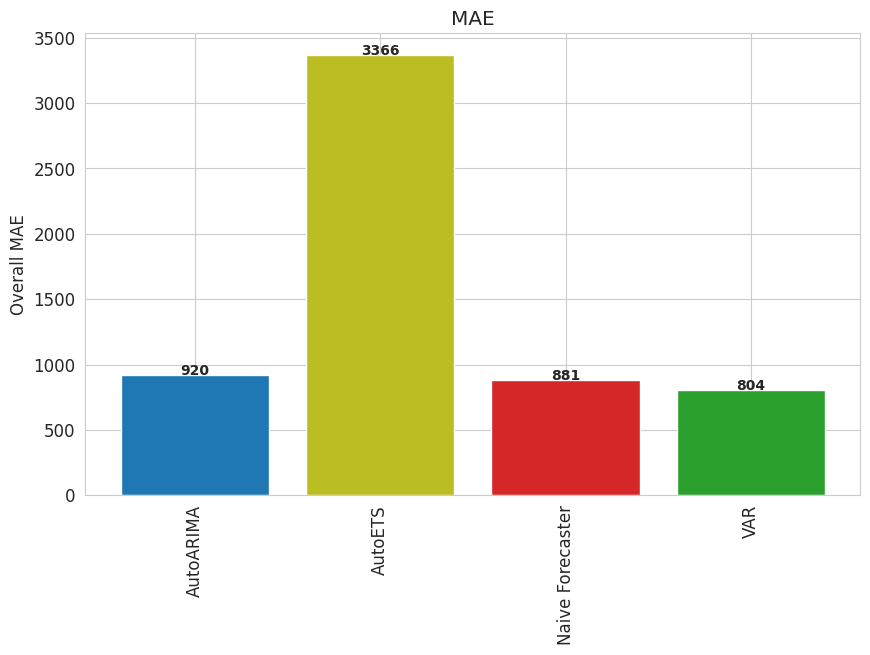

MAE for VAR:  803.6658082191782


In [160]:
mae_VAR = np.mean(df_eval_VAR["MAE"])

model = ["AutoARIMA", 'AutoETS', 'Naive Forecaster', 'VAR']
maes = [mae_ARIMA, mae_ETS, mae_naive, mae_VAR]

bar_colors = ['tab:blue', 'tab:olive', 'tab:red', 'tab:green']


fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(model,maes, color= bar_colors)
for index,data in enumerate(maes):
    plt.text(x=index , y =data+1 , s=f"{round(data)}" , fontdict=dict(fontsize=10), horizontalalignment ="center", fontweight = "bold")
plt.ylabel("Overall MAE")
plt.title('MAE')
plt.setp( ax.xaxis.get_majorticklabels(), rotation=90)
plt.show()

print("MAE for VAR: ",mae_VAR)

After evaluating the results of the VAR with the function that we described in Chapter 3, we see that we can achieve better results than other batch learning approaches when humidity is taken into account. This means that it makes sense to pursue further investigations regarding multivariate approaches.

## 6. Conclusion <a class="anchor" id="chapter6"></a>

## 6.1 Batch vs. Online <a class="anchor" id="section_6_1"></a>

While working on this case study, we conducted a series of experiments regarding the prediction of water demand in the Ruhr area. We used online machine-learning algorithms and classical batch-learning approaches. Before starting the experiments, we suspected that online machine-learning algorithms could improve training times and memory usage. This can be assumed since in OML, the models do not get retrained repeatedly with all available data but only updated incrementally. However, this often leads to performance degradation compared to classical methods. After evaluation, we surprisingly realized that OML algorithms performed better for water prediction based on the data than classical batch learning approaches. Thus, based on these experiments, online machine learning methods may be a more efficient alternative for predicting water consumption in the Ruhr Area. 

## 6.2 Univariate vs. Multivariate <a class="anchor" id="section_6_2"></a>

Similarly, we conducted experiements with two types of datasets i.e. univariate (single feature) and multivariate (multiple features). The local humidity values are considered in the multivariate dataset. We preprocessed and merged them to a seperate feature that includes information about the humidity in the whole Ruhr area. This way, we could improve the performance of our prediction. This experiment shows that it could make sense to investigate other environmental data. We only used the Vector Autoregression algorithm for this case study. Further investigations could be done with other multivariate models.

## References

* https://otexts.com/fpp2/holt-winters.html
* https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
* https://riverml.xyz
* https://www.statsmodels.org/stable/index.html
* https://github.com/Nixtla/statsforecast
* https://sktime.org
* https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
* https://github.com/sequential-parameter-optimization/spotRiver